## Gaussian Source Creation Sampling Factor Test - Low level Python

In [1]:
import math
import srwlib
from srwlib import *                               
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
## Function to create initial Gaussian wavefront
def createGsnSrc(sigrW,pulseE,poltype,phE=10e3,sampFact=15,nx=1000,ny=1000,mx=0,my=0):
    
    """
    #sigrW: beam size at waist [m]
    #pulseE: energy per pulse [J]
    #poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
    #phE: photon energy [eV]
    #sampFact: sampling factor to increase mesh density
    """
    
    constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
    rmsAngDiv = constConvRad/(phE*sigrW)             ##RMS angular divergence [rad]
    #sigrL=math.sqrt(sigrW**2+(propLen*rmsAngDiv)**2)  ##required RMS size to produce requested RMS beam size after propagation by propLen
    
        
    #***********Gaussian Beam Source
    GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
    GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
    GsnBm.y = 0
    GsnBm.z = 0 #Longitudinal Position of Waist [m]
    GsnBm.xp = 0 #Average Angles of Gaussian Beam at Waist [rad]
    GsnBm.yp = 0
    GsnBm.avgPhotEn = phE #Photon Energy [eV]
    GsnBm.pulseEn = pulseE #Energy per Pulse [J] - to be corrected
    GsnBm.repRate = 1 #Rep. Rate [Hz] - to be corrected
    GsnBm.polar = poltype #1- linear horizontal?
    GsnBm.sigX = sigrW #Horiz. RMS size at Waist [m]
    GsnBm.sigY = sigrW #Vert. RMS size at Waist [m]

    GsnBm.sigT = 10e-15 #Pulse duration [s] (not used?)
    GsnBm.mx = mx #Transverse Gauss-Hermite Mode Orders
    GsnBm.my = my

    #***********Initial Wavefront
    wfr = SRWLWfr() #Initial Electric Field Wavefront
    wfr.allocate(1, nx, ny) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
    wfr.mesh.zStart = 15.0 #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
    wfr.mesh.eStart = GsnBm.avgPhotEn #Initial Photon Energy [eV]
    wfr.mesh.eFin = GsnBm.avgPhotEn #Final Photon Energy [eV]

    wfr.unitElFld = 1 #Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

    distSrc = wfr.mesh.zStart - GsnBm.z
    #Horizontal and Vertical Position Range for the Initial Wavefront calculation
    #can be used to simulate the First Aperture (of M1)
    #firstHorAp = 8.*rmsAngDiv*distSrc #[m]
    xAp = 1.75601622e-3 #[m]
    yAp = xAp #[m]
    
    wfr.mesh.xStart = -0.5*xAp #Initial Horizontal Position [m]
    wfr.mesh.xFin = 0.5*xAp #Final Horizontal Position [m]
    wfr.mesh.yStart = -0.5*yAp #Initial Vertical Position [m]
    wfr.mesh.yFin = 0.5*yAp #Final Vertical Position [m]
    
    sampFactNxNyForProp = sampFact #sampling factor for adjusting nx, ny (effective if > 0)
    arPrecPar = [sampFactNxNyForProp]
    
    srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)
    
    
    return wfr

Initial wavefront calculation time: 0.29935 seconds
('Size of initial wavefront data array (coordinate):', (1248, 1248))


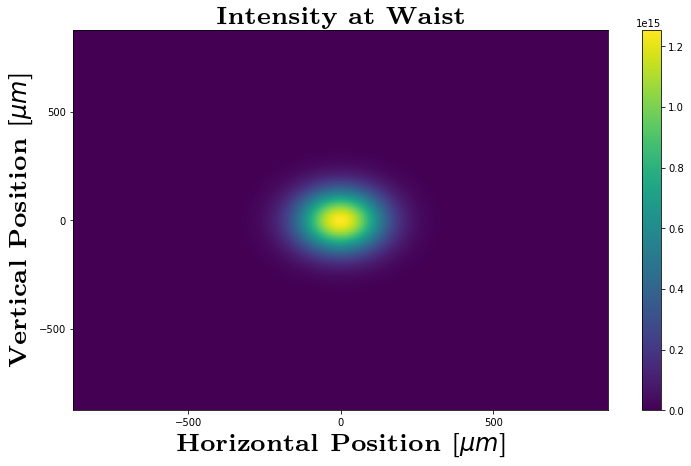

In [3]:
##Create Gaussian wavefront
#pulseE: energy per pulse [J]
#poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
#phE: photon energy [eV]
#sampFact: sampling factor to increase mesh density
#nx: no. of horizontal grid points for initial wavefront sampling
#ny: no. of vertical grid points for initial wavefront sampling

nx = 500
ny = 500
sigrW = 98e-6
pulseE = .001
poltype = 1
phE = 1.24e4
sampFact = .5 ##25, 44, 60
mx = 0
my = 0
wfr0=createGsnSrc(sigrW,pulseE,poltype,phE,sampFact,nx,ny,mx,my)

##Initial wfr calculation
start_time = time.time()
arI1 = array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI1, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arI12D = np.array(arI1).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
print("Initial wavefront calculation time: %s seconds" %(round((time.time() - start_time),5)))
wfrsizei=np.size(arI12D)

print('Size of initial wavefront data array (coordinate):',np.shape(arI12D))
xvals1=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvals1=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)


fig = plt.figure(figsize=(12,7))
ax = fig.gca()
plt.pcolormesh(np.multiply(xvals1,1e6), np.multiply(yvals1,1e6), arI12D, cmap=plt.cm.viridis)  ##By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.colorbar()
plt.rcParams['xtick.labelsize']=26
plt.rcParams['ytick.labelsize']=26
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)
plt.show()

In [4]:
## Calculate initial Gaussian wavefronts with varying sampling factors

#Sampling factor values
sampFactvals = np.linspace(.1,1.5,10)

Nvals=[]
tvals=[]

for sF in sampFactvals:
    
    ##Create Gaussian wavefront
    #pulseE: energy per pulse [J]
    #poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
    #phE: photon energy [eV]
    #sampFact: sampling factor to increase mesh density
    #nx: no. of horizontal grid points for initial wavefront sampling
    #ny: no. of vertical grid points for initial wavefront sampling
    nx = 1000
    ny = 1000
    sigrW = 98e-6
    pulseE = .001
    poltype = 1
    phE = 1.24e4
    sampFact = sF ##25, 44, 60
    constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
    rmsAngDiv = constConvRad/(phE*sigrW)
    mx = 0
    my = 0
    wfr0=createGsnSrc(sigrW,pulseE,poltype,phE,sampFact,nx,ny,mx,my)
    
    ##Initial wfr calculation
    start_time = time.time()
    arI1 = array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
    srwl.CalcIntFromElecField(arI1, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

    ##Reshaping electric field data from flat to 2D array
    arI12D = np.array(arI1).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
    print("Initial wavefront calculation time: %s seconds" %(round((time.time() - start_time),5)))

    Nvals.append(np.shape(arI12D)[0])
    tvals.append((round((time.time() - start_time),5)))
    print('Size of initial wavefront data array (coordinate):',np.shape(arI12D)[0])

Initial wavefront calculation time: 0.01048 seconds
('Size of initial wavefront data array (coordinate):', 250)
Initial wavefront calculation time: 0.07385 seconds
('Size of initial wavefront data array (coordinate):', 640)
Initial wavefront calculation time: 0.19994 seconds
('Size of initial wavefront data array (coordinate):', 1024)
Initial wavefront calculation time: 0.35896 seconds
('Size of initial wavefront data array (coordinate):', 1400)
Initial wavefront calculation time: 0.57915 seconds
('Size of initial wavefront data array (coordinate):', 1782)
Initial wavefront calculation time: 0.93132 seconds
('Size of initial wavefront data array (coordinate):', 2184)
Initial wavefront calculation time: 1.30353 seconds
('Size of initial wavefront data array (coordinate):', 2560)
Initial wavefront calculation time: 1.73668 seconds
('Size of initial wavefront data array (coordinate):', 2940)
Initial wavefront calculation time: 2.21521 seconds
('Size of initial wavefront data array (coordi

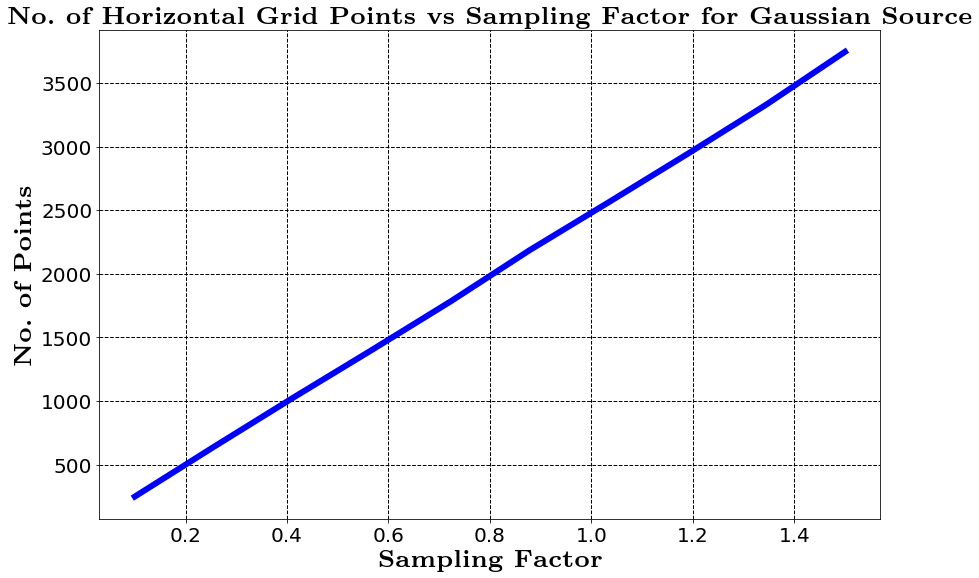

In [5]:
plt.rcParams.update({'legend.labelspacing':0.25, 'legend.handlelength': 2})
plt.rcParams.update({'xtick.labelsize':20,'ytick.labelsize':20})
fig = plt.figure(figsize=(14,9))
ax = fig.gca()
ax.plot(sampFactvals,Nvals, 'b-',linewidth=6.) 
ax.set_ylabel(r'No. of Points',**hfontLarge)
ax.set_xlabel(r'Sampling Factor',**hfontLarge)
ax.set_title('No. of Horizontal Grid Points vs Sampling Factor for Gaussian Source',**hfontLarge)
ax.grid(color='k', linestyle='dashed', linewidth=1)

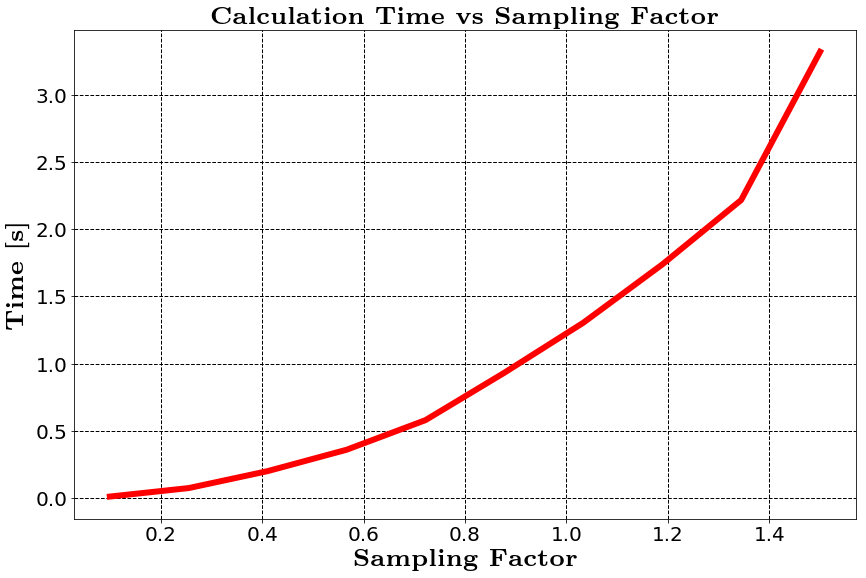

In [6]:
fig = plt.figure(figsize=(14,9))
ax = fig.gca()
ax.plot(sampFactvals,tvals, 'r-',linewidth=6.)
ax.set_ylabel(r'Time [s]',**hfontLarge)
ax.set_xlabel(r'Sampling Factor',**hfontLarge)
ax.set_title('Calculation Time vs Sampling Factor',**hfontLarge)
ax.grid(color='k', linestyle='dashed', linewidth=1)